# Regresión lineal.
## Introducción

En el capítulo anterior, hemos visto algunas características básicas de Pytorch, como por ejemplo cómo poder construir tensores, operar con ellos, calcular derivadas, etc.

En este apartado, nos adentramos un poco más en este campo y procederemos paso a paso a ver cómo poder utilizar los procedimientos que nos ofrece Pytorch para poder hacer un sencillo análisis de regresión simple, que como se sabe de lo que se trata es de encontrar los parámetros b y w de una recta de regresión que minimicen los errores (método de mínimos cuadrados ordinarios), es decir se trata de hacer mínima la función de coste:

$$f.coste = \frac{1}{n}\sum_{i=1}^{n}(\hat{y}_{i}-y_{i})^{2}​$$

Siendo $\hat{y}_{i}$ el valor esperado mediante la recta de regresión:

$$\hat{y}_{i}=b+w\cdot x_i$$

Vamos inicialmente a crear de forma artificial una serie de datos para su posterior tratamiento

In [3]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

In [2]:
true_b=1 #Valor verdadero de B
true_w=2 #Valor verdadero de w
N = 100

np.random.seed(42)
# Generamos números aleatorios para x
x = np.random.rand(N,1)
# generamos la variable de ruido
# randn para generar datos de una distribución normal
epsilon = (0.1*np.random.randn(N,1))
# generamos los datos de la variable dependiente
y = true_b + true_w * x + epsilon

Los puntos obtenidos tendrán el siguiente diagrama de dispersión.

Text(0.5, 1.0, 'Diagrama de dispersión de los puntos')

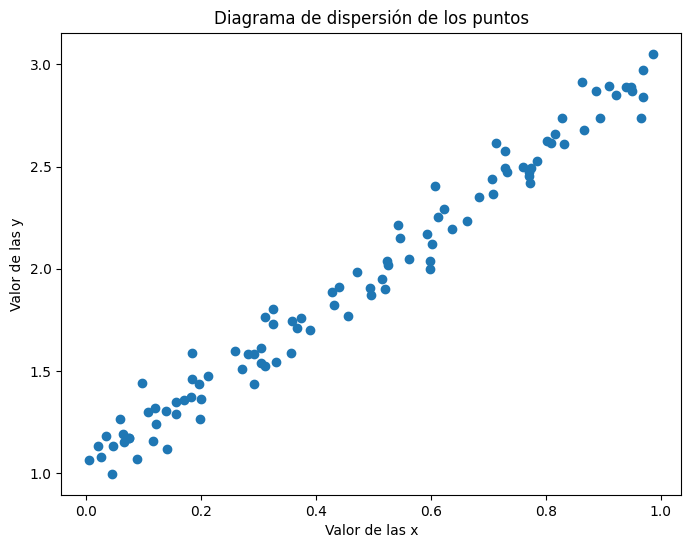

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(x,y)
plt.xlabel("Valor de las x")
plt.ylabel("Valor de las y")
plt.title("Diagrama de dispersión de los puntos")

Con la celda anterior, hemos generado 100 números de manera que tienen "cierta dependencia lineal" y los parámetros a los que nos "debemos acercar" con las estimaciones que hagamos deberán de ser: b = 1 y w=2.

A continuación procedemos a generar los datos de entrenamiento y de test

In [4]:
# Shuffles de los índices
idx = np.arange(N)
np.random.shuffle(idx)
# 80 por ciento para train
train_idx = idx[:int(N*.8)]
# El resto para test
val_idx = idx[int(N*.8):]
# Generamos el conjunto de datos de train y de test
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Creamos los tensores correspondientes

In [5]:
import torch

x_train_tensor = torch.as_tensor(x_train)
x_train.dtype, x_train_tensor.dtype

(dtype('float64'), torch.float64)

Se puede cambiar la precisión de los números que conforman el tensor

In [6]:
float_tensor = x_train_tensor.float()
float_tensor.dtype

torch.float32

En muchas ocasiones hay que decidir si se trabaja en CPU o en GPU (por defecto Pytorch pone los tensores en CPU), todo depende de si se tiene o instalado *cuda*. Entonces para determinar el *device* sobre el que se puede trabajar, normalmente se ejecuta la siguiente instrucción 

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Si se tiene más de una tarjeta gráfica, se puede saber el número y el nombre de las mismas, con las siguiente instrucción:

In [8]:
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

GeForce GTX 950M


En este caso sólo se tendría una GPU con nombre *GeForce GTX 950M*.

Entonces, si se tiene un tensor, que por defecto está instalado en la CPU y se quiere pasar a la GPU, la traslación se haría de la siguiente manera

In [9]:
gpu_tensor = torch.as_tensor(x_train).to(device)
gpu_tensor[0]

tensor([0.7713], device='cuda:0', dtype=torch.float64)

In [10]:
len(gpu_tensor)

80

In [11]:
gpu_tensor.shape

torch.Size([80, 1])

Por lo tanto vamos a poner nuestros datos de entrenamiento a la GPU de la siguiente manera

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Nuestros datos estaban como numpy array, pero los transformamos
# en tensores PyTorch's y después los mandamos al device elegido

x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [13]:
# Veamos los tipos de datos con los que trabajamos
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


Como ya habíamos apuntado en algún apartado anterior, se puede pasar un tensor a un numpy array con la propiedad numpy(), pero veamos ahora qué ocurre por ejemplo con x_train_tensor = torch.as_tensor(x_train).float().to(device) que lo hemos pasado a cuda

In [14]:
back_to_numpy = x_train_tensor.numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Resulta que nos da error y el motivo está en que de esa manera no se puede pasar de forma directa un tensor a un numpy array porque en este caso lo tenemos en la GPU. Hay que devolverlo primero a la cpu y después pasarlo a numpy array. Lo hacemos de la siguiente manera.

In [15]:
back_to_numpy = x_train_tensor.cpu().numpy()

## Creando parámetros.

En este modelo de regresión los parámetros van a ser b y w y son estos dos parámetros los que debemos ir modificando para que la función de coste sea mínima. Esta minimización se va a hacer mediante el uso de derivadas, y en concreto mediante gradientes. En Pytorch para hacer esto se debe utilizar la propiedad *requires_grad = True* para conseguirlo. Esto lo vamos a hacer de la siguiente manera

In [16]:
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
w = torch.randn(1, requires_grad=True, dtype=torch.float)
print(b, w)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


Como queremos pasar estos parámetros al device con el que estamos trabajando, realmente lo debemos hacer de la siguiente manera.

In [17]:
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
w = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(b, w)

tensor([0.3367], device='cuda:0', grad_fn=<CopyBackwards>) tensor([0.1288], device='cuda:0', grad_fn=<CopyBackwards>)


También se pueden crear de la siguiente manera

In [18]:
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
    dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
    dtype=torch.float, device=device)
print(b, w)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


## Autograd

Autograd es el acrónimo de *automatic differentiation package* y es el paquete que se encarga de hacer todo el proceso de cálculo de las derivadas.

```{index} autograd, backward
```

Con el método *backward* lo que se consigue es calcular el valor de todos los gradientes que tengamos en el proceso de producción. En nuestro caso lo que queremos es calcular los gradientes de la función de pérdida, lo cual se realiza de la siguiente manera.

In [19]:
# definimos la función de cálculo
yhat = b + w * x_train_tensor
#Definimos el error
error = (yhat - y_train_tensor)
# Definimos la función de pérdida (MSE)
loss = (error ** 2).mean()
#Por último calculamos el gradiente
loss.backward()

Veamos a continuación los tensores que realmente están implicados en el proceso de cálculo de gradientes

In [20]:
print(error.requires_grad, yhat.requires_grad, \
b.requires_grad, w.requires_grad)
print(y_train_tensor.requires_grad, x_train_tensor.requires_grad)

True True True True
False False


Observamos que de forma directa están b y w pero luego por la construcción que se ha hecho también están *error* y *yhat*.

```{index} grad
```
El valor concreto del gradiente lo obtenemos con el método *grad* de la siguiente manera


In [21]:
print(b.grad, w.grad)

tensor([-3.3881], device='cuda:0') tensor([-1.9439], device='cuda:0')


Es muy importante tener en cuenta que **el cálculo de gradientes con Pytorch es acumulativo** lo cual quiere decir que si se vuelve a calcular el gradiente con las mismas instrucciones anteriores se obtiene lo siguiente:

In [22]:
# definimos la función de cálculo
yhat = b + w * x_train_tensor
#Definimos el error
error = (yhat - y_train_tensor)
# Definimos la función de pérdida (MSE)
loss = (error ** 2).mean()
#Por último calculamos el gradiente
loss.backward()

print(b.grad, w.grad)

tensor([-6.7762], device='cuda:0') tensor([-3.8878], device='cuda:0')


Es decir se han duplicado los valores del gradiente. Por este motivo es muy importante en este tipo de trabajos tener esto en cuenta y no olvidarse de poner a cero el gradiente en cada paso. Esto se consigue con la propiedad *zero_*. Lo podemos con el siguiente código

In [23]:
# !!!!NUEVO. ponemos a cero los gradientes
b.grad.zero_(), w.grad.zero_()



# definimos la función de cálculo
yhat = b + w * x_train_tensor
#Definimos el error
error = (yhat - y_train_tensor)
# Definimos la función de pérdida (MSE)
loss = (error ** 2).mean()
#Por último calculamos el gradiente
loss.backward()

print(b.grad, w.grad)

tensor([-3.3881], device='cuda:0') tensor([-1.9439], device='cuda:0')


Ahora sí podemos ver que hemos puesto al comienzo del código el contador a cero y ya obtenemos el mismo valor que al comienzo. 

## Actualizando lo parámetros.

En este tipo de trabajo, la optimización se va haciendo de forma iterativa y siguiendo el sentido que nos va marcando el valor del gradiente y para hacer esto se necesita operar con la denominada *tasa de aprendizaje* o *learning rate* que la vamos a designar por *lr*. Entonces de forma iterativa vamos a hacer converger hacia los valores óptimos mediante la siguiente transformación que se hace en cada paso:

$$b = b-lr\cdot b.grad$$

$$w = w-lr\cdot w.grad$$

Esto lo hacemos utilizando el código siguiente

In [25]:
# Definimos learning rate
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    # No more manual computation of gradients! 
    # b_grad = 2 * error.mean()
    # w_grad = 2 * (x_tensor * error).mean()   
    # We just tell PyTorch to work its way BACKWARDS 
    # from the specified loss!
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate. But not so fast...
    # FIRST ATTEMPT - just using the same code as before
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # b = b - lr * b.grad
    # w = w - lr * w.grad
    # print(b)

    # SECOND ATTEMPT - using in-place Python assigment
    # RuntimeError: a leaf Variable that requires grad
    # has been used in an in-place operation.
    # b -= lr * b.grad
    # w -= lr * w.grad        
    
    # THIRD ATTEMPT - NO_GRAD for the win!
    # We need to use NO_GRAD to keep the update out of
    # the gradient computation. Why is that? It boils 
    # down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad
    
    # PyTorch is "clingy" to its computed gradients, we
    # need to tell it to let it go...
    b.grad.zero_()
    w.grad.zero_()
    
print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


Como podemos ver en la salida de este código el resultado que obtenemos para los parámetros b y w están muy cercanos a los valores que inicialmente se les ha dado (recordar que a b se le había asignado un valor de 1 y a w de 2 para generar los datos artificiales del modelo). 

Como se ha podido ver en el código anterior, casi todos los pasos se a hecho de forma manual, pero Pytorch tiene muchas estructuras que nos facilitan todos o casi todos estos procesos. A continuación procedemos a modificar el código anterior para in introduciendo herramientas de Pytorch con las que nos debemos ir familiarizando.

## Otimizadores.

Pytorch ya viene cargado con una serie de optimizadores, que <a href="https://pytorch.org/docs/stable/optim.html" target="_blank"> podemos encontrar en este enlace </a>. Uno de estos optimizadores es *Stochastic Gradient Descend (SGD)* que vamos a utilizar para llegar a optimizar la búsqueda de los parámetros b y w. También **muy importante**, al final de cada iteración no olvidarse de utilizar la propiedad *zero_grad* para poner a cero el gradiente. Este optimizador se va a definir de la siguiente manera:

optimizer = optim.SGD([b,w],lr=lr)

A continuación veamos cómo se implementa en el código anterior

In [26]:
### ¡¡¡ IMPORTANTE importar esto
import torch.optim as optim

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# AQUI INCLUIMOS EL OPTIMIZADOR
optimizer = optim.SGD([b, w], lr=lr)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient 
    # descent. How wrong is our model? That's the error! 
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate. No more manual update!
    # with torch.no_grad():
    #     b -= lr * b.grad
    #     w -= lr * w.grad
    optimizer.step()
    
    # No more telling Pytorch to let gradients go!
    # b.grad.zero_()
    # w.grad.zero_()
    optimizer.zero_grad()
    
print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## Función de pérdida.

Igualmente Pytorch dispone de una buena <a href="https://pytorch.org/docs/stable/nn.html#loss-functions" target="_blank"> cantidad de funciones de pérdida</a> y en esta sección vamos a ver cómo poderla introducir en nuestro código para tener que evitar escribir nosotros mismos esa función.

Como lo que necesitamos es minimmizar la suma de cuadrados (MSE) la función de pérdida que se va a utilizar <a "href=https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss" target="_blank"> es nn.MSELoss </a>.

El formato que vamos a emplear es el siguiente:

loss_fn = nn.MSELoss(reduction='mean')

Veamos a continuación en nuestro ejemplo cómo introducimos este nuevo elemento

In [27]:
import torch.nn as nn

lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

# ¡¡¡¡NUEVO. introducimos la función de pérdida.. Mean squaret error (media cuadrática)

loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # No more manual loss!
    # error = (yhat - y_train_tensor)
    # loss = (error ** 2).mean()
    # ¡¡¡¡¡NUEVO utilizamos la función de pérdida
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    
print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


In [28]:
# Veamos cuanto vale la función de pérdida
loss

tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)

Observemos qué pasa si lo pasamos a un numpy array como hemos dicho anteriormente (tenemos en este caso un error)

In [43]:
loss.cpu().numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Obtenemos un error porque este tensor esta afectado por el cálculo de los gradientes, entonces para conseguir nuestro objetivo lo que tenemos que hacer es lo siguiente

In [44]:
loss.detach().cpu().numpy()

array(0.00804466, dtype=float32)

Podemos emplear los métodos *item()* o *tilist()* para obtener un valor determinado

In [45]:
print(loss.item(), loss.tolist())

0.008044655434787273 0.008044655434787273


## El modelo.

El modelo lo vamos a utilizar en principio para definir los parámetros y actualizar la función de regresión. Este modelo no es más que una clase de Python  que hereda de la clase *nn.Module*. Veamos cómo la definimos en nuestro caso. 

In [29]:
class ManualLinearRegression(nn.Module): # La herencia
    def __init__(self):
        super().__init__()
        # To make "b" and "w" real parameters of the model,
        # we need to wrap them with nn.Parameter
        # definimos los parámetros
        self.b = nn.Parameter(torch.randn(1,
                                          requires_grad=True, 
                                          dtype=torch.float))
        self.w = nn.Parameter(torch.randn(1, 
                                          requires_grad=True,
                                          dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        # Devuelve el valor de la regresión
        return self.b + self.w * x

Al heredar de <a href="https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module" target="_blank"> *nn.Module* </a> podemos utilizar el método *parameters()*, obteniendo el siguiente resultado.

In [30]:
torch.manual_seed(42)
dummy = ManualLinearRegression()
list(dummy.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

```{index} Entry name
```

También podemos obtener el valor actual de los parámetros mediante el método *state_dict()*. Veamoslo

In [31]:
dummy.state_dict()


OrderedDict([('b', tensor([0.3367])), ('w', tensor([0.1288]))])

Veamos los valores del optimizador

In [32]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [0, 1]}]}

Para pasar nuestro modelo a un device lo debemos hacer de la siguiente manera:

In [33]:
torch.manual_seed(42)
# Creates a "dummy" instance of our ManualLinearRegression model
# and sends it to the device
dummy = ManualLinearRegression().to(device)

Al final nuestro código nos quedaría de la siguiente manera

In [34]:
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device) ## NUEVO AÑADIDO

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    model.train() # What is this?!?

    # Step 1 - Computes model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor) ## NUEVO AÑADIDO
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    
# We can also inspect its parameters using its state_dict
print(model.state_dict())

OrderedDict([('b', tensor([1.0235], device='cuda:0')), ('w', tensor([1.9690], device='cuda:0'))])


Observar en el código anterior que hemos añadido *model.train()*, esto es una buena práctica para indicar que estamos en un proceso de entrenamiento de modelo.

## Definición de redes neuronales.

En los códigos anteriores, nosotros mismos hemos procedido a generar de manera manual la ecuación de regresión, sin embargo este procedimiento se puede omitir y utilizar para ello la posibilidad de definir una red neuronal adecuada para este problema. Lo haremos con el modelo *Linear* de Pytorch.

En este caso se necesita definir una *feature* de entrada y otra de salida, lo haremos así

In [35]:
linear = nn.Linear(1, 1)
linear

Linear(in_features=1, out_features=1, bias=True)

Podemos ver los parámetros que antes hemos definido como b y w de la siguiente forma

In [36]:
linear.state_dict()

OrderedDict([('weight', tensor([[-0.2191]])), ('bias', tensor([0.2018]))])

En este caso el parámetro b sería reconocido mediante *bias* y el w mediante *weight*. Ahora se podría construir el modelo definiéndolo de la siguiente manera:

In [37]:
class MyLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear model
        # with a single input and a single output
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        # Now it only takes a call
        self.linear(x)

Veamos cuales son ahora los parámetros del modelo

In [38]:
torch.manual_seed(42)
dummy = MyLinearRegression().to(device)
list(dummy.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

In [39]:
dummy.state_dict()

OrderedDict([('linear.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear.bias', tensor([0.8300], device='cuda:0'))])

## Modelos secuenciales.

El ejemplo anterior es un sencillo ejemplo de red neuronal muy simple. Estas redes se pueden complicar todo lo que queramos, pero existen unos modelos denominados secuenciales que engloban al modelo definido anteriormente. Estos modelos se construyen con la expresión *nn.Sequential()* y como parámetro se le puede añadir el modelo lineal que se desee probar. Por ejemplo en nuestro caso, ese modelo se puede definir de la siguiente manera

In [40]:
torch.manual_seed(42)
# Alternatively, you can use a Sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)
model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')),
             ('0.bias', tensor([0.8300], device='cuda:0'))])

Este tipo de modelos se pueden combinar entre sí para construir redes neuronales que se agrupan en diversas capas como puede verse en la siguiente figura.

![redes neuronale](figuras/redes.PNG)

En ejemplo anterior, tendremos una red neuronal con una capa de entrada que se definiría por *nn.Linear(3,5)* (ya que tiene 3 inputs y genera 5 salidas o output), en el medio tiene una capa oculta y se genera una salida de una unidad, quedaría definida como *nn.Linear(5,1)*. Podriamos concatenar todo esto mediante un modelo secuencial de la siguiente manera:

In [41]:
torch.manual_seed(42)
# Building the model from the figure above
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4414,  0.4792, -0.1353],
                      [ 0.5304, -0.1265,  0.1165],
                      [-0.2811,  0.3391,  0.5090],
                      [-0.4236,  0.5018,  0.1081],
                      [ 0.4266,  0.0782,  0.2784]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0815,  0.4451,  0.0853, -0.2695,  0.1472], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2060, -0.0524, -0.1816,  0.2967, -0.3530]], device='cuda:0')),
             ('1.bias', tensor([-0.2062], device='cuda:0'))])

Para definir el anterior modelo no hemos dado nombre a las diferentes capas, por lo que las nombra mediante una serie de etiquetas numéricas. Se puede usar el método *add_module()* para añadir capas con un nombre determinado de la siguiente manera.

In [42]:
torch.manual_seed(42)
# Building the model from the figure above
model = nn.Sequential()
model.add_module('layer1', nn.Linear(3, 5))
model.add_module('layer2', nn.Linear(5, 1))
model.to(device)

Sequential(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

Con todos los elementos indicados anteriormente ya tenemos conocimiento más que suficiente para poder montar de forma adecuada nuestro modelo de regresión lineal simple. Para hacer esto, dividiremos el trabajo en tres partes:

* Preparación de los datos

* Configuración del modelo

* Entrenamiento del modelo

Veremos cada una de las tres partes en los próximos apartados, pero antes de seguir adelante y puesto que lo utilizaremos posteriormente, conviene explicar una serie de *comandos mágicos de jupyter* ya que gracias a ellos mejoraremos el conocimiento del proceso de construcción de este tipo de redes.

:::{note}
* %writefile . Lo que hace es guardar en un fichero el contenido de la celda, de esa manera depués lo podremos ejecutar

* %run. Ejecuta el fichero que se le indica en este comando, y si además se utiliza %run -i tiene en cuenta los valores de todas las variables con las que se esté trabajando en jupyter notebook.

Gracias a este sistema, vamos a poder ir construyendo y mejorando modelos sobre otros sin que tengamos que repetir código.
:::

Así que de esta manera, procedemos a elaborar nuestro artefacto de trabajo, construyendo los tres elementos indicados anteriormente.

## Preparación de lo datos.

En este paso incorporamos los siguientes comandos:

**NOTA:** Antes de ejecutar la celda siguiente hay que crear una carpeta denominada *data_preparation* contenida en la misma carpeta que contiene este jupyter notebook. 

In [43]:
y_train.shape

(80, 1)

In [44]:
%%writefile data_preparation/v0.py
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors and then we send them to the
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

Overwriting data_preparation/v0.py


In [45]:
x_train.shape

(80, 1)

In [46]:
x_train_tensor.shape

torch.Size([80, 1])

In [47]:
y_train.shape

(80, 1)

In [48]:
y_train_tensor.shape

torch.Size([80, 1])

Ahora si queremos ejecutar el trozo de código anterior, lo haríamos de la siguiente manera

In [49]:
%run -i data_preparation/v0.py

## Configuración de modelo.

En este segundo apartado, vamos a definir los siguientes elementos:

* Un modelo

* Una función de pérdida (loss function).

* Un optimizador

Todo lo anterior lo tenemos en el siguiente código (construir antes una carpeta denominada *model_configuration*):

In [50]:
%%writefile model_configuration/v0.py

# This is redundant now, but it won't be when we introduce
# Datasets...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_configuration/v0.py


In [51]:
# Lo ejecutamos mediante 
%run -i model_configuration/v0.py

## Modelo de entrenamiento

El modelo lo construimos así (antes se debe crear la carpeta *model_training*)

In [52]:
%%writefile model_training/v0.py

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

Overwriting model_training/v0.py


In [53]:
# Lo ejecutamos mediante
%run -i model_training/v0.py

## Ejemplo de uso de este método.

En los anteriores apartados hemos creado y estimado los parámetros de una regresión lineal simple en base a unos datos sintéticos. En este apartado vamos a aplicar lo visto en los anteriores apartados, pero a datos provenientes de un fichero de datos real. Este fichero de datos lo obtenemos de los ficheros que por defecto contiene scikit learn. Lo hacemos de la siguiente manera

In [146]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [147]:
# cargamos los datos
df = pd.read_csv("datos/Pecan.csv")
df.head()

,Water per acre,Salinity level,Fertilizer per acre,Pecan Production
0,68.138954,45.916165,42.896806,406.064207
1,79.907342,42.998570,49.763432,442.476260
2,75.301620,43.715734,48.242166,433.672569
3,91.255560,35.568128,53.779698,467.941026
4,100.998049,24.689234,50.967590,510.038689


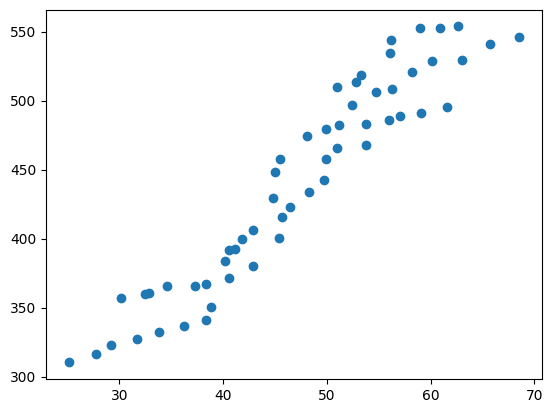

In [148]:
plt.scatter(df["Fertilizer per acre"],df["Pecan Production"])

Con el gráfico anterior, podemos ver que la nube de puntos se puede ajustar bien mediante un modelo de regresión lineal simple. Como este ejemplo está hecho sólo con fines didácticos, y además no contamos con muchos puntos, no vamos a dividir el conjunto de datos entre entrenamiento y test, simplemente vamos a ver qué parámetros se estiman mediante scikit-learn y los comparamos con los que se obtienen con un modelo de redes neuronales.

In [149]:
from sklearn.linear_model import LinearRegression

In [150]:
X=df.values[:, 2].reshape(-1,1)
y= df.values[:,3]

In [151]:
X.shape

(56, 1)

In [152]:
y.shape

(56,)

In [153]:
from sklearn.preprocessing import MinMaxScaler
# escalamos los valores entre [0,1]
scaler = MinMaxScaler()

X=df.values[:, 2].reshape(-1,1)
X=scaler.fit_transform(X)
y= df.values[:,3].reshape(-1,1)
y=scaler.fit_transform(y)

In [154]:
model = LinearRegression().fit(X,y)

In [155]:
# Parámetro del modelo
print(model.coef_)

[[1.19635686]]


In [156]:
# Parámetro intercepto
print(model.intercept_)

[-0.0730295]


Con esto datos vamos a construir la red neuronal correspondiente y proceder a la estimación de los parámetros

In [159]:
import torch

# preparación del modelo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#X=df.values[:, 2].reshape(-1,1)
#y= df.values[:,3].reshape(-1,1)
x_train_tensor2 = torch.as_tensor(X).float().to(device)
y_train_tensor2= torch.as_tensor(y).float().to(device)

In [160]:
X.shape

(56, 1)

In [161]:
x_train_tensor2.shape

torch.Size([56, 1])

In [162]:
y.shape

(56, 1)

In [163]:
y_train_tensor2.shape

torch.Size([56, 1])

In [164]:
import torch.optim as optim
import torch.nn as nn


lr = 0.1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)


optimizer = optim.SGD(model.parameters(), lr=lr)


loss_fn = nn.MSELoss(reduction='mean')

In [165]:
model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')),
             ('0.bias', tensor([0.8300], device='cuda:0'))])

In [166]:
# Entrenamiento del modelo
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train_tensor2)
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor2)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

In [167]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.1963]], device='cuda:0')),
             ('0.bias', tensor([-0.0730], device='cuda:0'))])

# Apéndice.

* <a href="https://machinelearningmastery.com/making-predictions-with-multilinear-regression-in-pytorch/?utm_source=drip&utm_medium=email&utm_campaign=Making+predictions+with+multilinear+regression+in+PyTorch&utm_content=Making+predictions+with+multilinear+regression+in+PyTorch" target="_blank"> Haciendo predicciones </a>

* <a href="https://machinelearningmastery.com/training-a-single-output-multilinear-regression-model-in-pytorch/?utm_source=drip&utm_medium=email&utm_campaign=Making+predictions+with+multilinear+regression+in+PyTorch&utm_content=Making+predictions+with+multilinear+regression+in+PyTorch" target="_blanK">Entrenando el modelo de regresión multilineal en pyTorch</a>